# News Category Classification with Supervised Learning

A report focused on modeling news article categorization for marketing analytics. This notebook focuses on the application of natural language processing, supervised learning with k-train (a wrapper for Tensorflow, Keras, and Huggingface Transformers), and a evaluation of performance.

## Introduction

## Loading Dependencies

In [1]:
# File Connection and File Manipulation
import os
import time
import pickle
import json
import glob
# Basic Data Science Toolkits
import pandas as pd
import numpy as np
import math
import time
# Basic Data Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
# Import Data Model Evaluations
from sklearn.model_selection import train_test_split
from sklearn import metrics
# NLP Tokenizer
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from keras.preprocessing.text import Tokenizer
# Google's Tensorflow package
# https://www.tensorflow.org/tutorials
import tensorflow as tf
print(tf.__version__)
# API wrapper for Tensorflow called ktrain
# https://github.com/amaiya/ktrain
import ktrain
from ktrain import text
from ktrain.text import texts_from_df
#NLP Text Cleanup
import re
import nltk
import nltk.corpus
from nltk.corpus import stopwords

# NLP Tokenizer and Lemmatizer
import nltk
import nltk.corpus
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

2.10.1


In [2]:
#Install the necessary datasets/models for specific functions to work
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Test to confirm the download worked
from nltk.corpus import brown
brown.words()
#dir(nltk)

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar 21 16:52:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.52                 Driver Version: 551.52         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   55C    P8             14W /  115W |     404MiB /   8192MiB |     30%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 14.9 gigabytes of available RAM

Not using a high-RAM runtime


## Loading Data

In [2]:
ROOT_DIR = "./"
DATA_DIR = "%s/data" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

#Create missing directories, if they don't exist
if not os.path.exists(DATA_DIR):
  # Create a new directory because it does not exist
  os.makedirs(DATA_DIR)
  print("The data directory is created!")
if not os.path.exists(EVAL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(EVAL_DIR)
  print("The evaluation directory is created!")
if not os.path.exists(MODEL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(MODEL_DIR)
  print("The model directory is created!")

In [7]:
import urllib.request
url = 'https://docs.google.com/uc?export=download&id=1jnucfZWLPmxG4UzPtgd-dRe_Z9tPo60V'
filename = './data/news_category_trainingdata.json'
urllib.request.urlretrieve(url, filename)

('./data/news_category_trainingdata.json',
 <http.client.HTTPMessage at 0x22ca298e0b0>)

In [8]:
# Read the data into a datframe
df_news = pd.read_json(filename)

In [9]:
# Merge two text column for the model
df_news['combined_text'] = df_news['headline'] + ' ' + df_news['short_description']
# Create a flag of welness related articles
cat_list_wellness = ['HEALTHY LIVING', 'WELLNESS']
df_news['wellness'] = np.where((df_news['category'].isin(cat_list_wellness)), 1, 0)

In [10]:
# Preview the new dataframe
df_news.head()

,category,headline,authors,link,short_description,date,combined_text,wellness
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0


## EDA

In [11]:
# show the content of one Article in the data source
idx = 0
print('category:', df_news['category'][idx], '\t wellness:', df_news['wellness'][idx],'\n')
print('headline:', df_news['headline'][idx], '\n')
print('short_description:', df_news['short_description'][idx], '\n')
print('combined_text:', df_news['combined_text'][idx], '\n')

category: CRIME 	 wellness: 0 

headline: There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV 

short_description: She left her husband. He killed their children. Just another day in America. 

combined_text: There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV She left her husband. He killed their children. Just another day in America. 



In [12]:
# Create a summary of the categories
df_cat_count = pd.DataFrame(df_news['category'].value_counts()).reset_index()
df_cat_count.reset_index()
df_cat_count.columns = ['category', 'count']
# Derive Stats vand Lists
cat_list = list(df_cat_count['category'].unique())
cat_list_wellness = ['HEALTHY LIVING', 'WELLNESS']
cat_list_not_wellness = list(set(cat_list) - set(cat_list_wellness))
total_categories = len(cat_list)
total_wellness_cats = len(cat_list_wellness)
total_not_wellness_cats = len(cat_list_not_wellness)
# Print a Summary
print('Total Categories:', total_categories)
print('Wellness Categories:', total_wellness_cats, '\n\tList:', cat_list_wellness)
print('Non-Wellness Categories:', total_not_wellness_cats, '\n\tList:', cat_list_not_wellness)

Total Categories: 41
Wellness Categories: 2 
	List: ['HEALTHY LIVING', 'WELLNESS']
Non-Wellness Categories: 39 
	List: ['WEDDINGS', 'CRIME', 'WORLD NEWS', 'TECH', 'BLACK VOICES', 'TASTE', 'GOOD NEWS', 'MEDIA', 'QUEER VOICES', 'FOOD & DRINK', 'HOME & LIVING', 'SPORTS', 'PARENTING', 'PARENTS', 'DIVORCE', 'WEIRD NEWS', 'STYLE', 'ENTERTAINMENT', 'IMPACT', 'RELIGION', 'MONEY', 'BUSINESS', 'COLLEGE', 'TRAVEL', 'LATINO VOICES', 'STYLE & BEAUTY', 'FIFTY', 'WORLDPOST', 'POLITICS', 'ARTS', 'GREEN', 'ENVIRONMENT', 'THE WORLDPOST', 'ARTS & CULTURE', 'EDUCATION', 'SCIENCE', 'CULTURE & ARTS', 'WOMEN', 'COMEDY']


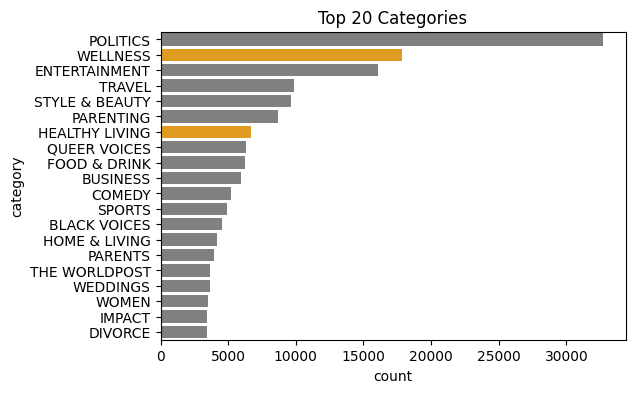

In [13]:
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,4))
cols = ['orange' if (y in ['WELLNESS', 'HEALTHY LIVING']) else 'grey' for y in df_cat_count['category']]
sns.barplot(x = 'count',
            y = 'category',
            data = df_cat_count.head(20),
            palette=cols
            ).set(title='Top 20 Categories',)
plt.show()

In [14]:
# Preview the Split of Data
df_news['wellness'].value_counts()

wellness
0    176332
1     24521
Name: count, dtype: int64

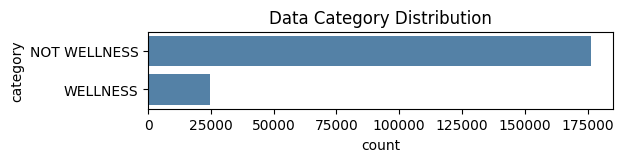

In [15]:
# Create a summary of the categories
df_wellness_count = pd.DataFrame(df_news['wellness'].value_counts()).reset_index()
df_wellness_count.columns = ['category', 'count']
dict_target_names = {0: 'NOT WELLNESS', 1: 'WELLNESS'}
df_wellness_count['category'].replace(dict_target_names, inplace=True)
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,1))
sns.barplot(x = 'count',
            y = 'category',
            data = df_wellness_count,
            color = 'steelblue'
            ).set(title='Data Category Distribution',)
plt.show()

Text(0, 0.5, 'Record Count')

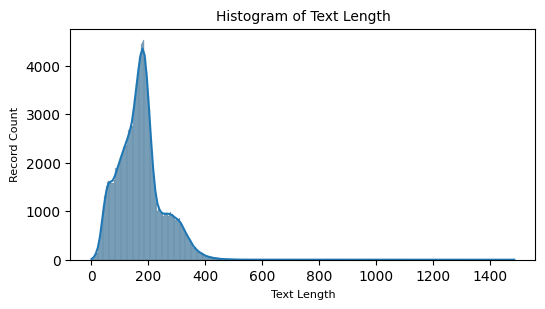

In [16]:
# add a length column to the dataframe
df_news['text_length'] = df_news['combined_text'].apply(len)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a histogram of the length of text
#chart = plt.hist(x = df_s['Text Length'])
chart = sns.histplot(x = df_news['text_length'], kde=True)
# Customising legend
ax.set_title('Histogram of Text Length', fontsize=10)
ax.set_xlabel('Text Length', fontsize=8)
ax.set_ylabel('Record Count', fontsize=8)

Text(0.5, 1.0, 'Boxplot of Text Length')

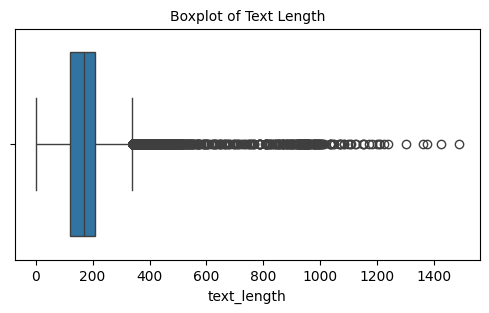

In [17]:
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a boxplot of the length of text
chart = sns.boxplot(x = df_news['text_length'])
ax.set_title('Boxplot of Text Length', fontsize=10)

Text(0.5, 1.0, 'Boxplot of Word Count')

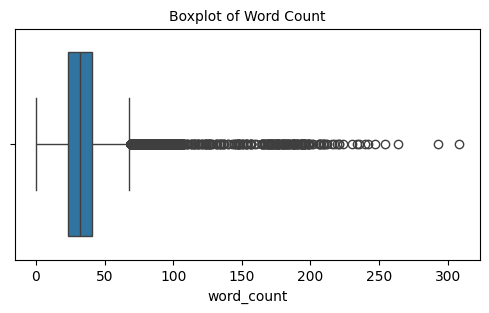

In [18]:
# define a function to add the word count to a dataframe
def add_word_count(df):
    df['text_token'] = df.apply(lambda row: nltk.word_tokenize(row['combined_text']), axis=1)
    df['word_count'] = df['text_token'].apply(len)
    df.drop(columns = ['text_token'], inplace=True)
    return df
# add a length column to the dataframe for wordcount
df_news = add_word_count(df = df_news)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a boxplot of the length of text
chart = sns.boxplot(x = df_news['word_count'])
ax.set_title('Boxplot of Word Count', fontsize=10)

## Data Cleaning

In [19]:
# Identify Columns with Nulls
def identify_columns_with_null(df):
  a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
  nc = {}

  for c in df.columns:
      string_null = np.array([x in a[2:] for x in df[c]]).sum()
      std_null = df[c].isnull().sum()
      ttl_null = std_null + string_null
      if ttl_null > 0:
          nc[c] = ttl_null

  print('number of fields with nulls:', len(nc), '\n')
  print(pd.Series(nc))

  return nc

In [20]:
# Detect Columns with null values
null_columns = identify_columns_with_null(df = df_news)

number of fields with nulls: 4 

headline                 6
authors              36620
short_description    19712
combined_text            5
dtype: int64


In [21]:
df_news['combined_text'].replace('', np.nan, inplace=True)
df_news['headline'].replace('', np.nan, inplace=True)
df_news.dropna(subset=['combined_text'], inplace=True)
df_news.dropna(subset=['headline'], inplace=True)
null_columns = identify_columns_with_null(df = df_news)

number of fields with nulls: 2 

authors              36620
short_description    19707
dtype: int64


In [22]:
# Create a funtion to clean a dataframe with text
def clean_text(df, text_col):
    # removes punctuation
    df['no_punct'] = df[text_col].apply(
        lambda row: re.sub(r'[^\w\s]+', '', row))
    # removes numbers
    df['no_punct_num'] = df['no_punct'].apply(
        lambda row: re.sub(r'[0-9]+', '', row))
    # removes stop words, e.g. a, an, and, but, in, on, the...
    stop_words = stopwords.words('english')
    df['no_stopwords'] = df['no_punct_num'].apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # removes extra spaces
    df['clean_text'] = df['no_stopwords'].apply(
        lambda x: re.sub(' +', ' ', x))
    # tidy the table
    df.drop(columns = ['no_punct','no_punct_num','no_stopwords'], inplace=True)
    return

In [23]:
# Tokenize text functions
wordnet_lemmatizer = WordNetLemmatizer()
# Function to bulkify lemmatize large block of text one word at a time
def lemmatizer(text):
    lem = [wordnet_lemmatizer.lemmatize(word.lower()) for word in text]
    return lem
# Function to tokenize the entire article then apply the lemmatize to each article
def tokenize_lemmatize(df, text_col):
    df['tokenized_text'] = df.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    df['lemmatized_text'] = df['tokenized_text'].apply(lambda string: lemmatizer(string))
    return

In [24]:
# will not use this function as it does not work with LLMs
def deep_clean(df, text_col, preview_idx = 0):
  idx = preview_idx
  # Change the text to lowercase
  df[text_col] = df[text_col].str.lower()
  # Using 'clean_text' function to clean 'Text' column
  clean_text(df = df, text_col = text_col)
  # Preview the changes for the before and after text
  print(df[text_col][idx])
  print('\n## change to ##\n')
  print(df['clean_text'][idx])
  print('\n--------------------\n')
  # Tidy the table
  df[text_col] = df['clean_text']
  df.drop(columns = ['clean_text'], inplace=True)
  # Using text cleaning function to clean the text column
  tokenize_lemmatize(df = df, text_col = text_col)
  # Print a before an after of the tokenization and lematization
  print(df[text_col][idx])
  print('\n## change to ##\n')
  print(df['lemmatized_text'][idx])
  print('\n--------------------\n')
  # Tidy the table
  df[text_col] = df.apply(lambda row: ' '.join(row['lemmatized_text']), axis=1)
  df.drop(columns = ['tokenized_text', 'lemmatized_text'], inplace=True)
  # Print a final preview of the text
  print('## final text ##\n')
  print(df[text_col][idx])

#deep_clean(df = df_news, text_col = 'combined_text', preview_idx = 0)

In [25]:
# Set a sample amount
sample_amount = 20000
# Sample healthy living
healthy = df_news[df_news['wellness'] == 1].sample(n = sample_amount)
# Sample non-healthy living
not_healthy = df_news[df_news['wellness'] == 0]
not_healthy_rows = len(not_healthy)
not_healthy_sample_frac = sample_amount / not_healthy_rows
not_healthy = not_healthy.groupby('category').apply(
    lambda x: x.sample(frac = not_healthy_sample_frac))
not_healthy = not_healthy.droplevel(0)
# Create a Sampled Dataset
df_news_sample = pd.concat([healthy, not_healthy])
# Preview the Split of Data
print(df_news_sample['wellness'].value_counts(), '\n')
# Confirm all categories are represented
sample_cat_list = list(df_news_sample['category'].unique())
total_sample_cats = len(sample_cat_list)
print('Sample Categories:', total_sample_cats, '\n\tList:', sample_cat_list)

wellness
1    20000
0    20000
Name: count, dtype: int64 

Sample Categories: 41 
	List: ['WELLNESS', 'HEALTHY LIVING', 'ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE', 'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS', 'GREEN', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES', 'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE', 'TECH', 'THE WORLDPOST', 'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WOMEN', 'WORLD NEWS', 'WORLDPOST']


In [26]:
# Create a summary of the categories
df_sample_cat_count = pd.DataFrame(df_news_sample['category'].value_counts()).reset_index()
df_sample_cat_count.reset_index()
df_sample_cat_count.columns = ['category', 'count']

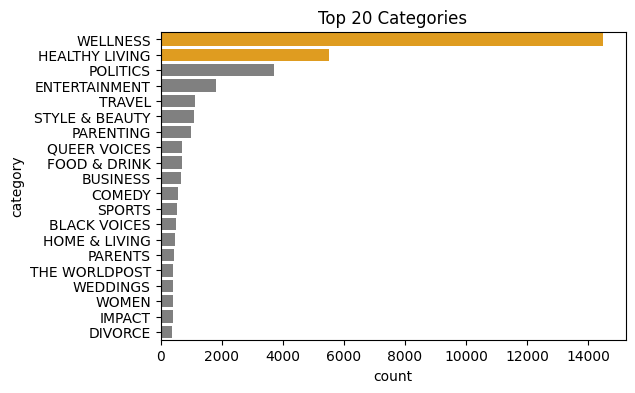

In [27]:
# Create a summary bar chart of categories
cols = ['orange' if (y in ['WELLNESS', 'HEALTHY LIVING']) else 'grey' for y in df_sample_cat_count['category']]
f = plt.figure(figsize=(6,4))
sns.barplot(x = 'count',
            y = 'category',
            data = df_sample_cat_count.head(20),
            palette=cols
            ).set(title='Top 20 Categories')
plt.show()

In [28]:
# Preview the Split of Data
df_news_sample['wellness'].value_counts()

wellness
1    20000
0    20000
Name: count, dtype: int64

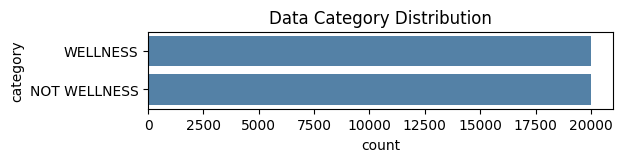

In [29]:
# Create a summary of the categories
df_samp_wellness_count = pd.DataFrame(df_news_sample['wellness'].value_counts()).reset_index()
df_samp_wellness_count.columns = ['category', 'count']
dict_target_names = {0: 'NOT WELLNESS', 1: 'WELLNESS'}
df_samp_wellness_count['category'].replace(dict_target_names, inplace=True)
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,1))
sns.barplot(x = 'count',
            y = 'category',
            data = df_samp_wellness_count,
            color = 'steelblue'
            ).set(title='Data Category Distribution',)
plt.show()

In [30]:
df_news_sample.head(3)

,category,headline,authors,link,short_description,date,combined_text,wellness,text_length,word_count
197389,WELLNESS,Relaxing 101: Expert Tips To Reduce Stress And...,,https://www.huffingtonpost.com/entry/reduce-st...,"By Ysolt Usigan for Shape.com These days, ever...",2012-03-05,Relaxing 101: Expert Tips To Reduce Stress And...,1,176,38
151387,WELLNESS,"Arianna Talks Third Metric, The Importance Of ...","Huff TV, Contributor\nContributor",https://www.huffingtonpost.com/entry/arianna-c...,"America's current model of of success, with it...",2013-07-10,"Arianna Talks Third Metric, The Importance Of ...",1,194,38
139464,WELLNESS,Whole Person Health Care Brings Out Your Inner...,"Ingrid Peschke, Contributor\nReligion, Spiritu...",https://www.huffingtonpost.com/entry/whole-hea...,"As lifestyle medicine takes off, my hope is th...",2013-11-13,Whole Person Health Care Brings Out Your Inner...,1,310,56


## Building our Models



### Parameter Tuning

In [31]:
target_names = ['NOT WELLNESS','WELLNESS']

In [34]:
#I've chosen distilbert-base-uncased because it's a good compromise between size and performance.
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

In [35]:
# use the distilbert-base-uncased transformer model
# See all the models here: https://huggingface.co/transformers/pretrained_models.html
train, val, preprocess = texts_from_df(df_news_sample, 'combined_text',
                                       label_columns = ['wellness'],
                                       val_df = None,
                                       max_features = 20000,
                                       maxlen = 512,
                                       val_pct = 0.1,
                                       ngram_range = 1,
                                       preprocess_mode = 'distilbert')

['not_wellness', 'wellness']
        not_wellness  wellness
156358           1.0       0.0
136904           0.0       1.0
149860           0.0       1.0
147910           0.0       1.0
124973           1.0       0.0
['not_wellness', 'wellness']
        not_wellness  wellness
142987           0.0       1.0
11332            1.0       0.0
22628            1.0       0.0
51334            1.0       0.0
5634             1.0       0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


In [39]:
model = ktrain.text.text_classifier('distilbert', train_data=train, preproc=preprocess)
learner = ktrain.get_learner(model=model,
                             train_data=train,
                             val_data=val,
                             batch_size=8)

Is Multi-Label? False
maxlen is 512
done.


In [42]:
learner.fit_onecycle(
    lr = 3e-5,
    #3e-5 -- value from smaller runs
    #1e-4 -- value from labs,
    checkpoint_folder = 'checkpoint',
    epochs = 12)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/12
4500/4500 [==============================] - 1319s 289ms/step - loss: 0.2756 - accuracy: 0.8897 - val_loss: 0.2093 - val_accuracy: 0.9193
Epoch 2/12
4500/4500 [==============================] - 1171s 259ms/step - loss: 0.1866 - accuracy: 0.9305 - val_loss: 0.1980 - val_accuracy: 0.9260
Epoch 3/12
4500/4500 [==============================] - 1161s 257ms/step - loss: 0.1289 - accuracy: 0.9532 - val_loss: 0.2111 - val_accuracy: 0.9218
Epoch 4/12
4500/4500 [==============================] - 1170s 259ms/step - loss: 0.0823 - accuracy: 0.9711 - val_loss: 0.2838 - val_accuracy: 0.9147
Epoch 5/12
4500/4500 [==============================] - 1168s 258ms/step - loss: 0.0594 - accuracy: 0.9795 - val_loss: 0.2696 - val_accuracy: 0.9222
Epoch 6/12
4500/4500 [==============================] - 1165s 258ms/step - loss: 0.0474 - accuracy: 0.9847 - val_loss: 0.3352 - val_accuracy: 0.9168
Epoch 7/12
4500/4500 [=====================

In [43]:
# Save the learner
learner.save_model("%s/distilbertmodel_learner" % DATA_DIR)

In [44]:
# Returns a Predictor instance that can be used to make predictions on unlabeled examples
predictor = ktrain.get_predictor(learner.model, preproc = preprocess)

In [45]:
# Save the predictor model
predictor.save("%s/distilbertmodel_predictor" % DATA_DIR)

### Validate the Model

In [46]:
# Returns confusion matrix and optionally prints a classification report.
validation = learner.validate(val_data = val,
                              print_report = True,
                              class_names = target_names)

125/125 [==============================] - 19s 136ms/step
              precision    recall  f1-score   support

NOT WELLNESS       0.91      0.92      0.91      1929
    WELLNESS       0.93      0.91      0.92      2071

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



## Model Evaluation

In [47]:
# Show the data stored in the validation
validation

array([[1780,  149],
       [ 183, 1888]], dtype=int64)

In [48]:
# Save confusion matrix and slice into four pieces
TP = validation[1, 1]
TN = validation[0, 0]
FP = validation[0, 1]
FN = validation[1, 0]

In [49]:
# Calculate metrics from confusion matrix
c_accuracy            = (TP + TN) / (TP + TN + FP + FN)
c_error               = (FP + FN) / (TP + TN + FP + FN)
c_sensitivity         = TP / (TP + FN)
c_specificity         = TN / (TN + FP)
c_false_positive_rate = FP / (TN + FP)
c_precision           = TP / (TP + FP)
c_f1                  = (c_sensitivity + c_precision) / 2

In [50]:
# Print a summary of additional metrics
print('Accuracy:\t\t', round(c_accuracy,4)*100, '%')
print('Classification Error:\t', round(c_error,4)*100, '%')
print('Sensitivity / Recall:\t', round(c_sensitivity,4)*100, '%')
print('Specificity:\t\t', round(c_specificity,4)*100, '%')
print('False Positive Rate:\t', round(c_false_positive_rate,4)*100, '%')
print('Precision:\t\t', round(c_precision,4)*100, '%')
print('F1 Score:\t\t', round(c_f1,4)*100, '%')

Accuracy:		 91.7 %
Classification Error:	 8.3 %
Sensitivity / Recall:	 91.16 %
Specificity:		 92.28 %
False Positive Rate:	 7.720000000000001 %
Precision:		 92.69 %
F1 Score:		 91.92 %


In [ ]:
# Load predictor from save (if needed for analysis)
#predictor = ktrain.load_predictor("%s/distilbertmodel_predictor" % DATA_DIR)
#model = ktrain.get_predictor(predictor.model, predictor.preproc)

In [4]:
# Sample articles to test sourced on 2023-09-12
test_docs = [
'Is swimming in cold water good for you? Cold water exposure has arousing and stimulating effects, and it appears to increase many substances that we know are involved in regulating mood.',
'For jet lag, a hearty breakfast in the new time zone may help Eating an early meal in the new time zone and avoiding a meal late the night before could mean two fewer days of jet lag, a mathematical model showed.',

'Overdoses soared even as prescription opioid shipments plunged The number of prescription opioid pain pills shipped in the United States plummeted nearly 45 percent from 2011 to 2019, federal data shows, even as fatal overdoses hit record levels as users turned to heroin and then fentanyl.',
'Thousands missing and feared dead after floods submerge eastern Libya The International Federation of Red Cross and Red Crescent Societies said its independent sources reported up to 10,000 people missing.',
'The U.S. commitment to Ukraine has worried me deeply. Then a friend went. Jim and I agree on pretty much everything — just not Ukraine.'
             ]

In [5]:
# create a prediciton for human sourced articles (no real category assigned)
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is wellness is %s' % round(probs[1],4))
  print(text)

---------------------------
The probability this is wellness is 1.0
Is swimming in cold water good for you? Cold water exposure has arousing and stimulating effects, and it appears to increase many substances that we know are involved in regulating mood.
---------------------------
The probability this is wellness is 1.0
For jet lag, a hearty breakfast in the new time zone may help Eating an early meal in the new time zone and avoiding a meal late the night before could mean two fewer days of jet lag, a mathematical model showed.
---------------------------
The probability this is wellness is 0.773
Overdoses soared even as prescription opioid shipments plunged The number of prescription opioid pain pills shipped in the United States plummeted nearly 45 percent from 2011 to 2019, federal data shows, even as fatal overdoses hit record levels as users turned to heroin and then fentanyl.
---------------------------
The probability this is wellness is 0.0
Thousands missing and feared dead a

In [53]:
# create a prediciton for all articles in corpus
val_probs = predictor.predict(list(df_news['combined_text']), return_proba=True)

In [54]:
# add predictions to dataframe
df_news['pred_proba'] = val_probs[:,1]
df_news['pred'] = np.where(df_news['pred_proba']>0.5, 1, 0)
df_news['pred_acc'] = (df_news['pred'] == df_news['wellness'])
df_news.head(2)

,category,headline,authors,link,short_description,date,combined_text,wellness,text_length,word_count,pred_proba,pred,pred_acc
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0,141,31,0.000005,0,True
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0,100,22,0.000005,0,True


In [55]:
# summarize record level flagging of accuracy in source data
pd.DataFrame(df_news['pred_acc'].value_counts())

,count
pred_acc,
True,187921
False,12926


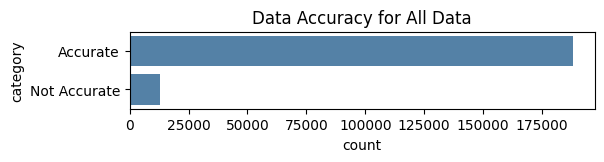

In [56]:
# Create a summary of the accuracy
df_pred_count = pd.DataFrame(df_news['pred_acc'].value_counts()).reset_index()
df_pred_count.columns = ['category', 'count']
dict_target_names = {False: 'Not Accurate', True: 'Accurate'}
df_pred_count['category'].replace(dict_target_names, inplace=True)
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,1))
sns.barplot(x = 'count',
            y = 'category',
            data = df_pred_count,
            color = 'steelblue'
            ).set(title='Data Accuracy for All Data',)
plt.show()

In [57]:
# Dump the evaluation dataframe to a file
pickle.dump(df_news, open('%s/all_pred.p' % (EVAL_DIR), 'wb'))

In [7]:
# Load the evaluation dataframe (if needed)
#df_news = pd.read_pickle(r'./evaluation/all_pred.p')

In [11]:
# Create a dataframe to focus only on wellness articles (subset)
df_news_target = df_news[df_news['wellness'] == 1]

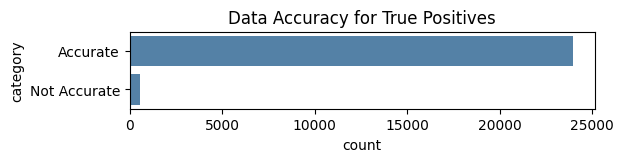

In [12]:
# Create a summary of the wellness predictions
df_pred_count = pd.DataFrame(df_news_target['pred_acc'].value_counts()).reset_index()
df_pred_count.columns = ['category', 'count']
dict_target_names = {False: 'Not Accurate', True: 'Accurate'}
df_pred_count['category'].replace(dict_target_names, inplace=True)
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,1))
sns.barplot(x = 'count',
            y = 'category',
            data = df_pred_count,
            color = 'steelblue'
            ).set(title='Data Accuracy for True Positives',)
plt.show()

In [3]:
# Load predictor from save (if needed for analysis)
predictor = ktrain.load_predictor("%s/distilbertmodel_predictor" % DATA_DIR)
model = ktrain.get_predictor(predictor.model, predictor.preproc)

In [7]:
!pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip

     - 0 bytes ? 0:00:00
     - 31.7 kB 1.6 MB/s 0:00:00
     \ 113.8 kB 1.4 MB/s 0:00:00
     \ 208.6 kB 1.6 MB/s 0:00:00
     | 256.7 kB 1.6 MB/s 0:00:00
     | 351.3 kB 1.6 MB/s 0:00:00
     / 361.5 kB 1.6 MB/s 0:00:00
     / 441.7 kB 1.4 MB/s 0:00:00
     - 541.5 kB 1.6 MB/s 0:00:00
     - 668.4 kB 1.7 MB/s 0:00:00
     \ 736.9 kB 1.7 MB/s 0:00:00
     \ 866.9 kB 1.7 MB/s 0:00:00
     | 973.2 kB 1.8 MB/s 0:00:00
     / 1.1 MB 1.9 MB/s 0:00:00
     / 1.1 MB 1.9 MB/s 0:00:00
     / 1.2 MB 1.8 MB/s 0:00:00
     - 1.3 MB 1.8 MB/s 0:00:00
     \ 1.5 MB 2.0 MB/s 0:00:00
     \ 1.5 MB 2.0 MB/s 0:00:00
     | 1.6 MB 1.8 MB/s 0:00:00
     | 1.7 MB 1.9 MB/s 0:00:00
     / 1.7 MB 1.8 MB/s 0:00:00
     / 1.7 MB 1.8 MB/s 0:00:01
     - 1.8 MB 1.7 MB/s 0:00:01
     - 1.9 MB 1.8 MB/s 0:00:01
     \ 2.0 MB 1.8 MB/s 0:00:01
     \ 2.2 MB 1.9 MB/s 0:00:01
     | 2.4 MB 1.9 MB/s 0:00:01
     | 2.5 MB 2.0 MB/s 0:00:01
     / 2.7 MB 2.0 MB/s 0:00:01
     - 2.7 MB 2.0 MB/s 0:00:01
     - 2.8 MB 2.0 MB/s

In [11]:
# Explanation of prediction
predictor.explain(test_docs[0])

In [9]:
# Explanation of prediction
predictor.explain(test_docs[2])

In [10]:
# Explanation of prediction
predictor.explain(test_docs[4])